На основе ТЕХНИЧЕСКОГО РЕГЛАМЕНТА ТАМОЖЕННОГО СОЮЗА "О БЕЗОПАСНОСТИ ЖЕЛЕЗНОДОРОЖНОГО ПОДВИЖНОГО СОСТАВА" сделайте нейро-консультанта, отвечающего на вопросы по документу и поддерживающему диалог. Установите адекватный порог релевантности чанков (используйте similarity_search_with_score вместо similarity_search), то есть, для ответа на вопрос пользователя у вас должны подтягиваться только чанки, находящиеся в пределах данного порога, а остальные - отбрасываться.
Проработайте промпт самостоятельно. Нейро-консультант не должен отвечать на вопросы, не касающиеся документа, то есть, он, если скоры всех найденных чанков выше определенного, установленного вами, порога, то нейро-консультант должен отвечать фразу-заглушку.
Сделайте нейро-консультанта, проверьте его работу на самостоятельно-сформулированных вопросах. В ответе нейро-консультанта выводите также скоры найденных чанков (не только отфильтрованных, а всех, найденных при помощи метода similarity_search_with_score).

Ссылка на регламент: https://docs.google.com/document/d/1YhUEX9fZDNTeE3eJ-yXskxZG46LsTRYvXjZ9Ij-t3Gw/edit?usp=sharing

In [ ]:
!pip install -q faiss-cpu==1.8.0 sentence_transformers mistralai  tiktoken==0.7.0 langchain-core==0.2.33 langchain==0.2.14 langchain_community==0.2.12 langchain-text-splitters==0.2.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 391.5/391.5 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.8/997.8 kB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.0/260.0 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.8/311.8 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 3.0 MB/s eta 0:00:00


In [ ]:
# импортируем необходимые библиотеки
from mistralai import Mistral
from sentence_transformers import SentenceTransformer
from langchain.text_splitter import RecursiveCharacterTextSplitter, MarkdownHeaderTextSplitter, CharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain.document_loaders import TextLoader
from langchain.docstore.document import Document
import os
import re
import requests
import tiktoken
import matplotlib.pyplot as plt
from textwrap import fill

import logging
logging.getLogger("langchain.text_splitter").setLevel(logging.ERROR)

In [ ]:
# запустите эту ячейку, если используете секретный ключ в колабе
from google.colab import userdata
api_key = userdata.get("MISTRAL_API_KEY")
os.environ["MISTRAL_API_KEY"] = api_key

# Создание клиента OpenAI с использованием API ключа из переменных среды
client = Mistral(api_key)

In [ ]:
# функция для загрузки документа по ссылке из гугл драйв
def load_document_text(url: str) -> str:
    # Extract the document ID from the URL
    match_ = re.search('/document/d/([a-zA-Z0-9-_]+)', url)
    if match_ is None:
        raise ValueError('Invalid Google Docs URL')
    doc_id = match_.group(1)

    # Download the document as plain text
    response = requests.get(f'https://docs.google.com/document/d/{doc_id}/export?format=txt')
    response.raise_for_status()
    text = response.text

    return text

In [ ]:
# База знаний, которая будет подаваться в langChain
data_from_url= load_document_text('https://docs.google.com/document/d/1YhUEX9fZDNTeE3eJ-yXskxZG46LsTRYvXjZ9Ij-t3Gw/edit?usp=sharing') # заполните аргумент функции

In [ ]:
data_from_url[:10000]

'\ufeffТЕХНИЧЕСКИЙ РЕГЛАМЕНТ\r\nТАМОЖЕННОГО СОЮЗА "О БЕЗОПАСНОСТИ ЖЕЛЕЗНОДОРОЖНОГО\r\nПОДВИЖНОГО СОСТАВА"\r\n \r\n(ТР ТС 001/2011)\r\n \r\n\r\n\r\n\t \r\nI. Область применения\r\n \r\n1. Настоящий технический регламент распространяется на вновь разрабатываемые (модернизируемые), изготавливаемые железнодорожный подвижной состав с конструкционной скоростью до 200 км/ч включительно и его составные части (далее - продукция), выпускаемые в обращение на таможенной территории Евразийского экономического союза (далее - Союз) для использования на железнодорожных путях общего и необщего пользования с шириной колеи 1 520 мм.\r\nЖелезнодорожный подвижной состав включает в себя:\r\nлокомотивы;\r\nмоторвагонный подвижной состав и его вагоны;\r\nпассажирские вагоны локомотивной тяги;\r\nгрузовые вагоны;\r\nспециальный железнодорожный подвижной состав.\r\nПеречень объектов технического регулирования, на которые распространяются требования настоящего технического регламента, приведен в приложении N 1.\

Предобрабатываем БЗ таким образом, чтобы можно было разметить ее в формате маркдаун разметки

In [ ]:
def text_to_markdown(text):
    # Добавляем заголовок 1 уровня на основе римских чисел (без переноса строки)
    # и дублируем его строчкой ниже - иначе эта информация перенесется в метаданные, а порой она бывает полезной.
    def replace_header1(match):
        return f"# {match.group(2)}\n{match.group(2)}"

    text = re.sub(r'^(I{1,3}|IV|V|VI{1,3}|IX)\. (.+)', replace_header1, text, flags=re.M)

    # Добавляем текст, выделенный жирным шрифтом (он заключен между *)
    # и дублируем его строчкой ниже
    def replace_header2(match):
        return f"## {match.group(1)}\n{match.group(1)}"

    text = re.sub(r'\*([^\*]+)\*', replace_header2, text)

    return text

In [ ]:
markdown = text_to_markdown(data_from_url)
print(markdown[:15000])

﻿ТЕХНИЧЕСКИЙ РЕГЛАМЕНТ
ТАМОЖЕННОГО СОЮЗА "О БЕЗОПАСНОСТИ ЖЕЛЕЗНОДОРОЖНОГО
ПОДВИЖНОГО СОСТАВА"
 
(ТР ТС 001/2011)
 


	 
# Область применения
Область применения
 
1. Настоящий технический регламент распространяется на вновь разрабатываемые (модернизируемые), изготавливаемые железнодорожный подвижной состав с конструкционной скоростью до 200 км/ч включительно и его составные части (далее - продукция), выпускаемые в обращение на таможенной территории Евразийского экономического союза (далее - Союз) для использования на железнодорожных путях общего и необщего пользования с шириной колеи 1 520 мм.
Железнодорожный подвижной состав включает в себя:
локомотивы;
моторвагонный подвижной состав и его вагоны;
пассажирские вагоны локомотивной тяги;
грузовые вагоны;
специальный железнодорожный подвижной состав.
Перечень объектов технического регулирования, на которые распространяются требования настоящего технического регламента, приведен в приложении N 1.
2. Настоящий технический регламент не распр

In [ ]:
# Инструкция в system
system = load_document_text('https://docs.google.com/document/d/1GYaMlh4wD_NCez-8l5lV2o7yQM8H9Sai2sK-TxALYbE/edit?tab=t.0') # заполните аргумент ссылкой на составленный вами промпт. Не забудьте открыть доступ

In [ ]:
print(system[:1000])

﻿Ты консультант по регламенту ТАМОЖЕННОГО СОЮЗА "О БЕЗОПАСНОСТИ ЖЕЛЕЗНОДОРОЖНОГО ПОДВИЖНОГО СОСТАВА”. Ответь на вопрос клиента, основываясь исключительно на предоставленной информации. Не добавляй никаких личных мнений или интерпретаций, отвечай максимально точно и подробно на основе содержимого. Не упоминай о наличии документа или источника информации. Клиент не должен знать о существовании документа, на основе которого ты формируешь ответ. Убедись, что все ответы ясны, логичны и соответствуют действующим нормам и правилам в области экологической экспертизы.


In [ ]:
def num_tokens_from_string(string: str, encoding_name: str) -> int:
      """Возвращает количество токенов в строке"""
      encoding = tiktoken.get_encoding(encoding_name)
      num_tokens = len(encoding.encode(string))
      return num_tokens

def split_text(text, max_count):
    headers_to_split_on = [
        ("#", "Header 1"),
        ("##", "Header 2"),
    ]

    markdown_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)
    fragments = markdown_splitter.split_text(text)

    # Подсчет токенов для каждого фрагмента и построение графика
    fragment_token_counts = [num_tokens_from_string(fragment.page_content, "cl100k_base") for fragment in fragments]
    plt.hist(fragment_token_counts, bins=50, alpha=0.5, label='Fragments')
    plt.title('Distribution of Fragment Token Counts')
    plt.xlabel('Token Count')
    plt.ylabel('Frequency')
    plt.show()

    splitter = RecursiveCharacterTextSplitter(
        chunk_size=max_count,
        chunk_overlap=0,
        length_function=lambda x: num_tokens_from_string(x, "cl100k_base")
    )

    source_chunks = [
        Document(page_content=chunk, metadata=fragment.metadata)
        for fragment in fragments
        for chunk in splitter.split_text(fragment.page_content)
    ]

    # Подсчет токенов для каждого source_chunk и построение графика
    source_chunk_token_counts = [num_tokens_from_string(chunk.page_content, "cl100k_base") for chunk in source_chunks]
    plt.hist(source_chunk_token_counts, bins=20, alpha=0.5, label='Source Chunks')
    plt.title('Distribution of Source Chunk Token Counts')
    plt.xlabel('Token Count')
    plt.ylabel('Frequency')
    plt.show()

    return source_chunks, fragments

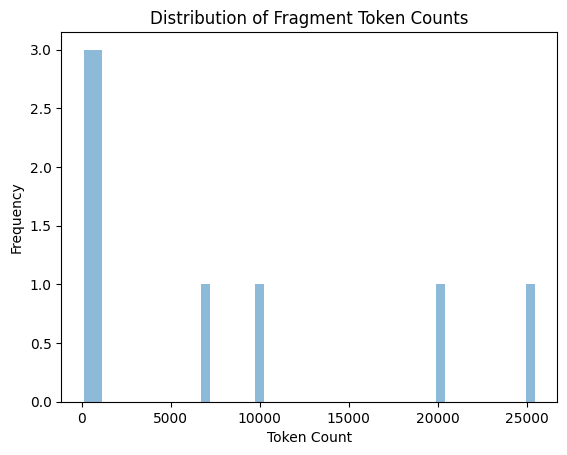

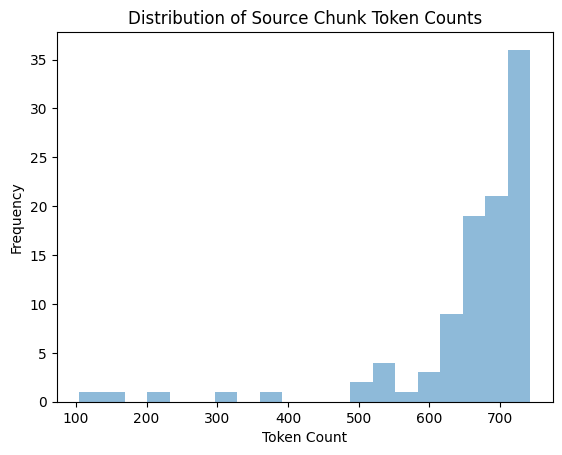

Общее количество чанков:  100


In [ ]:
source_chunks, fragments = split_text(markdown, 750)
print("Общее количество чанков: ",len(source_chunks))

In [16]:
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
# Функция для создания эмбеддингов из массива документов
def create_embeddings(documents):
    page_contents = [doc.page_content for doc in documents]
    return model.encode(page_contents)

# Создание эмбеддингов
embeddings = create_embeddings(source_chunks)

# Создадим индексную базу из разделенных фрагментов текста
import numpy as np
import faiss
# Преобразование эмбеддингов в массив numpy
embeddings = np.array(embeddings).astype('float32')

# Создание индекса FAISS
dimension = embeddings.shape[1]  # Размерность векторов
db = faiss.IndexFlatL2(dimension)  # Использование L2 метрики

# Добавление векторов в индекс
db.add(embeddings)

In [17]:
def insert_newlines(text: str, max_len: int = 170) -> str:
    """
    Функция разбивает длинный текст на строки определенной максимальной длины.
    """
    words = text.split()
    lines = []
    current_line = ""
    for word in words:
        if len(current_line + " " + word) > max_len:
            lines.append(current_line)
            current_line = ""
        current_line += " " + word
    lines.append(current_line)
    return "\n".join(lines)

In [26]:
def answer_index(system, topic, query_vector, source_chunks, search_index, verbose=1, threshold=10):
    # Поиск релевантных отрезков из базы знаний
    distances, indices =  search_index.search(query_vector, k=4)
    #indices_list = indices[0].tolist()
    # Вывод ближайших документов
    docs = [source_chunks[i] for i in indices[0]]
    scores = distances[0]
    if verbose: print('\n ===========================================: ')
    message_content = re.sub(r'\n{2}', ' ', '\n '.join([f'\nОтрывок документа №{i+1}\n=====================' + doc.page_content + f'\nscore: {scores[i]}\n' for i, doc in enumerate(docs)]))
    if verbose: print('message_content :\n ======================================== \n', message_content)

    # Фильтрация чанков по порогу
    filtered_docs = [doc for i, doc in enumerate(docs) if scores[i] <= threshold]
    if not filtered_docs:
        return "Извините, я не могу ответить на этот вопрос."

    filtered_message_content = re.sub(r'\n{2}', ' ', '\n '.join([f'\nОтрывок документа №{i+1}\n=====================' + doc.page_content + f'\nscore: {scores[i]}\n' for i, doc in enumerate(filtered_docs)]))

    client = Mistral(api_key=api_key)
    messages = [
        {"role": "system", "content": system},
        {"role": "user", "content": f"Ответь на вопрос. Документ с информацией для ответа: {filtered_message_content}\n\nВопрос пользователя: \n{topic}"}
    ]

    if verbose: print('\n ===========================================: ')

    completion = client.chat.complete(
        model="mistral-small-latest",             # выберите модель самостоятельно
        messages=messages,
        temperature=0          # укажите значение
    )
    answer = completion.choices[0].message.content
    return answer  # возвращает ответ

In [20]:
def summarize_questions(dialog):
    """
    Функция возвращает саммаризированный текст диалога.
    """
    messages = [
        {"role": "system", "content": "Ты - нейро-саммаризатор. Твоя задача - саммаризировать диалог, который тебе пришел. Если пользователь назвал свое имя, обязательно отрази его в саммаризированном диалоге"},
        {"role": "user", "content": "Саммаризируй следующий диалог консультанта и пользователя: " + " ".join(dialog)}
    ]

    completion = client.chat.complete(
        model="mistral-small-latest",             # выберите модель самостоятельно
        messages=messages,
        temperature=0          # укажите значение
    )

    return completion.choices[0].message.content

In [28]:
def answer_user_question_dialog(system, db, user_question, question_history, threshold):
    """
    Функция возвращает ответ на вопрос пользователя.
    """
    summarized_history = ""
    # Если в истории более одного вопроса, применяем суммаризацию
    if len(question_history) > 0:
        summarized_history = "Вот саммаризированный предыдущий диалог с пользователем: " +summarize_questions([q + ' ' + (a if a else '') for q, a in question_history])

    topic = summarized_history + " Актуальный вопрос пользователя: " + user_question

    # Получаем ответ, используя только user_question для поиска в базе данных
    query_vector = model.encode([user_question])
    query_vector = np.array(query_vector).astype('float32')

    answer_text = answer_index(system, topic, query_vector, source_chunks, db, 1, threshold)

    question_history.append((user_question, answer_text if answer_text else ''))
    # Выводим саммаризированный текст, который видит модель
    if summarized_history:
        print('****************************')
        print(summarized_history)
        print('****************************')

    return answer_text


In [29]:
# ваше решение
def run_dialog(system_doc_url, knowledge_base_url, threshold):
    """
    Функция запускает диалог между пользователем и нейро-консультантом.
    """
    #список кортежей, где каждый кортеж содержит пару вопрос-ответ, для отслеживания истории вопросов и ответов во время сессии диалога.
    question_history = []
    while True:
        user_question = input('Пользователь: ')
        if user_question.lower() == 'stop':
            break
        answer = answer_user_question_dialog(system_doc_url, knowledge_base_url, user_question, question_history, threshold)
        print('Консультант:', insert_newlines(answer))

    return

In [30]:
# проверьте работу нейро-консультанта на нескольких самостоятельно сгенерированных вопросах. Проверьте, что соблюдаются инструкции и поддерживается диалог
run_dialog(system, db, 0.7)

Пользователь: На какой тип подвижного состава распространяется данный технический регламент?

 ===========================================: 
message_content :
 
Отрывок документа №1
=====================Область применения  
1. Настоящий технический регламент распространяется на вновь разрабатываемые (модернизируемые), изготавливаемые железнодорожный подвижной состав с конструкционной скоростью до 200 км/ч включительно и его составные части (далее - продукция), выпускаемые в обращение на таможенной территории Евразийского экономического союза (далее - Союз) для использования на железнодорожных путях общего и необщего пользования с шириной колеи 1 520 мм.
Железнодорожный подвижной состав включает в себя:
локомотивы;
моторвагонный подвижной состав и его вагоны;
пассажирские вагоны локомотивной тяги;
грузовые вагоны;
специальный железнодорожный подвижной состав.
Перечень объектов технического регулирования, на которые распространяются требования настоящего технического регламента, приведен

In [31]:
# проверьте работу нейро-консультанта на нескольких самостоятельно сгенерированных вопросах. Проверьте, что соблюдаются инструкции и поддерживается диалог
run_dialog(system, db, 10)

Пользователь: Какие составные части включены в определение железнодорожного подвижного состава?

 ===========================================: 
message_content :
 
Отрывок документа №1
=====================44. Железнодорожный подвижной состав должен быть оборудован автоматическими тормозами, обеспечивающими при его торможении остановку в пределах допустимого тормозного пути.
Автоматические тормоза железнодорожного подвижного состава должны обладать необходимой функциональностью в различных условиях эксплуатации, обеспечивать остановку поезда при нарушении целостности тормозной магистрали, нарушении электрической цепи безопасности или при несанкционированном расцеплении единиц железнодорожного подвижного состава.
45. Автоматические тормоза должны обеспечивать возможность применения различных режимов торможения в зависимости от загрузки железнодорожного подвижного состава, длины состава и профиля железнодорожного пути.
46. Стоп-краны в пассажирских вагонах и моторвагонном подвижном соста